In [1]:

%matplotlib inline

In [132]:
from skimage.io import imread, imsave, imshow
import skimage
import numpy as np
from numpy import clip, dstack
from skimage import img_as_float, img_as_ubyte
from matplotlib import pyplot as plt
from matplotlib.pyplot import hist

In [14]:
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

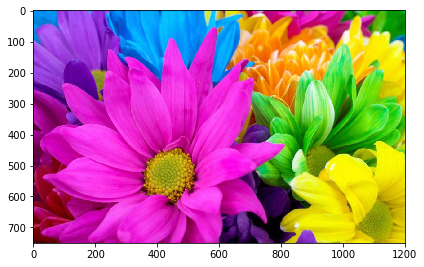

In [93]:
img = imread("https://avatars.mds.yandex.net/get-pdb/1025599/e0f9ae3d-039b-4d60-b3b0-ed11842643d5/s1200?webp=false")
imshow(img);

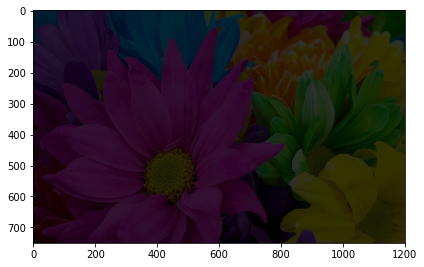

In [94]:
img_grey = img[:,:,0]
img_f = img_as_float(img)
dark = img_as_ubyte(clip(img_f*0.2,0,1));
imshow(dark);
img_grey = dark[:,:,0]

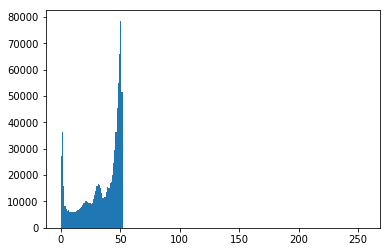

In [95]:
values, bin_edges, patches = hist(img_grey.ravel(), bins=range(257))

Функция, которая считает k% от всех пикселей и находит ymin и ymax

In [96]:
def y_min_max(img, k):
    k = round(img.size*k*0.01)
    # массив со значениями яркости для каждого пикселя
    brightness_array = np.array([img_grey[i][j] for j in range(img_grey.shape[1]) for i in range(img_grey.shape[0])])
    brightness_array = np.sort(brightness_array)
    y_min = brightness_array[k-1] # игнорируем k% 
    y_max = brightness_array[img.size - k]
    return (y_min,y_max)

In [97]:
y_min_max(img_grey, 5)

(1, 51)

In [98]:
def linear_stretching(img, k = 5):
    y_min, y_max = y_min_max(img, k)
    #y_min, y_max = 48, 225
    new_img = np.array([np.array([np.clip(np.uint8((px - y_min) * (255 / (y_max - y_min))), 0, 255)
            for px in row]) for row in img])
    return new_img

In [110]:
new_img = linear_stretching(img_grey)

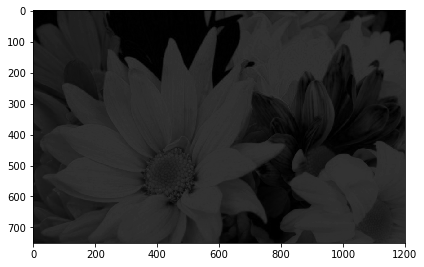

In [114]:
imshow(img_grey);
imsave('Grey.jpg',img_grey);

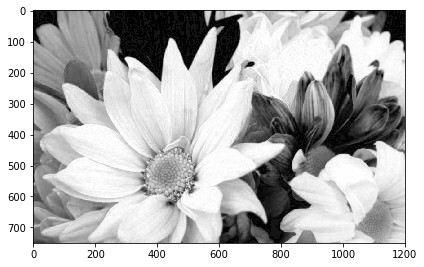

In [112]:
imshow(new_img);

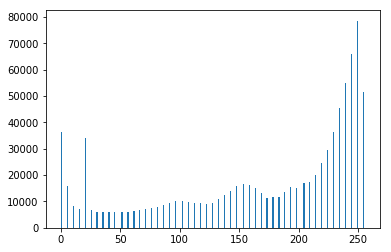

In [113]:
values, bin_edges, patches = hist(new_img.ravel(), bins=range(257))

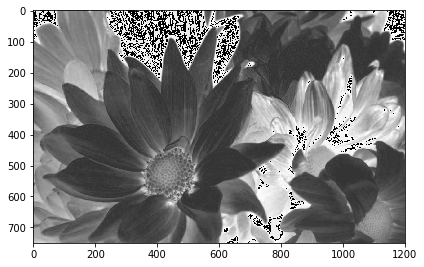

In [116]:
# Карта разности
imshow(np.abs(img_grey - new_img));

In [121]:
# Растяжение по каналам
def stretching_channels(img, k=5):
    R = linear_stretching(img[:,:,0],k)
    G = linear_stretching(img[:,:,1],k)
    B = linear_stretching(img[:,:,2],k)
    return np.uint8(dstack((R,G,B)))

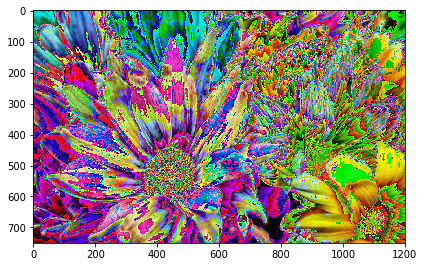

In [122]:
imshow(stretching_channels(img));

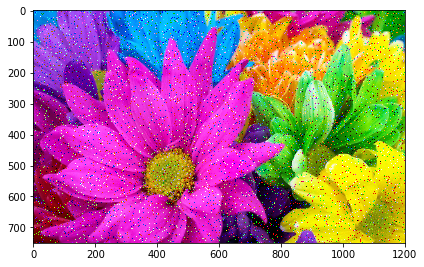

In [640]:
# Соль и перец
noise_img = skimage.util.random_noise(img, mode='s&p')
imshow(noise_img);

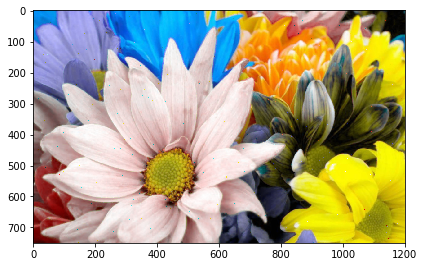

In [147]:
# Подавляем шум медианным фильтром размера 3
med = median_filter(noise_img, 3)
#skimage.filter.median_filter(image[, ...])
imshow(med);

In [138]:
from scipy.ndimage.filters import median_filter

In [650]:
def med_filter(img, kernel = 3):
    rows = img.shape[1]
    cols = img.shape[0]
    
    # Обработка границ - заполнение нулями
    zeros = np.zeros(img.shape[1])
    for i in range(kernel//2):
        img = np.vstack((zeros, img))
        img = np.vstack((img, zeros))
    zeros = np.zeros(img.shape[0])
    for i in range(kernel//2):
        img = np.hstack((np.atleast_2d(zeros).T, img))
        img = np.hstack((img, np.atleast_2d(zeros).T))
    
    # Перевод в одномерный массив
    img = img.reshape(1,(rows+2*(kernel//2))*(cols+2*(kernel//2)))[0]

    rows_0 = rows+2*(kernel//2)
    
    # Массив с новыми значениями
    new_img = np.zeros((cols,rows))
       
    temp = np.zeros(kernel**2)
    
    for j in range(cols):
        for i in range(rows):
            temp[:kernel] = img[i + j*rows_0:i + j*rows_0 + kernel]
            temp[kernel:kernel*2] = img[i + j*rows_0 + rows_0:i + j*rows_0 + rows_0 + kernel]
            temp[kernel*2:] = img[i + j*rows_0 + 2*rows_0: i + j*rows_0 + 2*rows_0 + kernel]
            new_img[j][i] = np.median(temp)    
    new_img = img_as_ubyte(new_img)
    return new_img

In [607]:
def med_channel(img):
    R = med_filter(img[:,:,0])
    G = med_filter(img[:,:,1])
    B = med_filter(img[:,:,2])
    return np.uint8(dstack((R,G,B)))

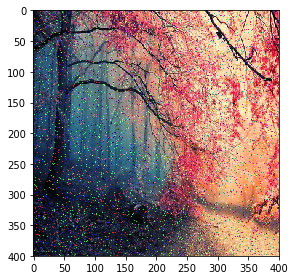

In [642]:
# Соль и перец
img1 = imread('https://cn.opendesktop.org/cache/400x400/img/d/3/8/b/dee28e853560a6bd0720d8318a29ca700d3b.jpg')
noise_img = skimage.util.random_noise(img1, mode='s&p')
imshow(noise_img);

CPU times: user 37.3 s, sys: 104 ms, total: 37.4 s
Wall time: 37.3 s


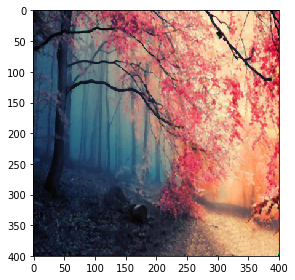

In [651]:
%%time
imshow(med_channel(noise_img));